# Shop Analysis

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from IPython.display import Image

In [2]:
from msci.utils import utils
from msci.analysis.networks import *

## Import data

In [21]:
signal_df = utils.import_signals('Mall of Mauritius', version=4, signal_type=1)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Mall of Mauritius

This is the largest of the three mall. It contains around 150 shops and recieves almost 700,000 people each month.

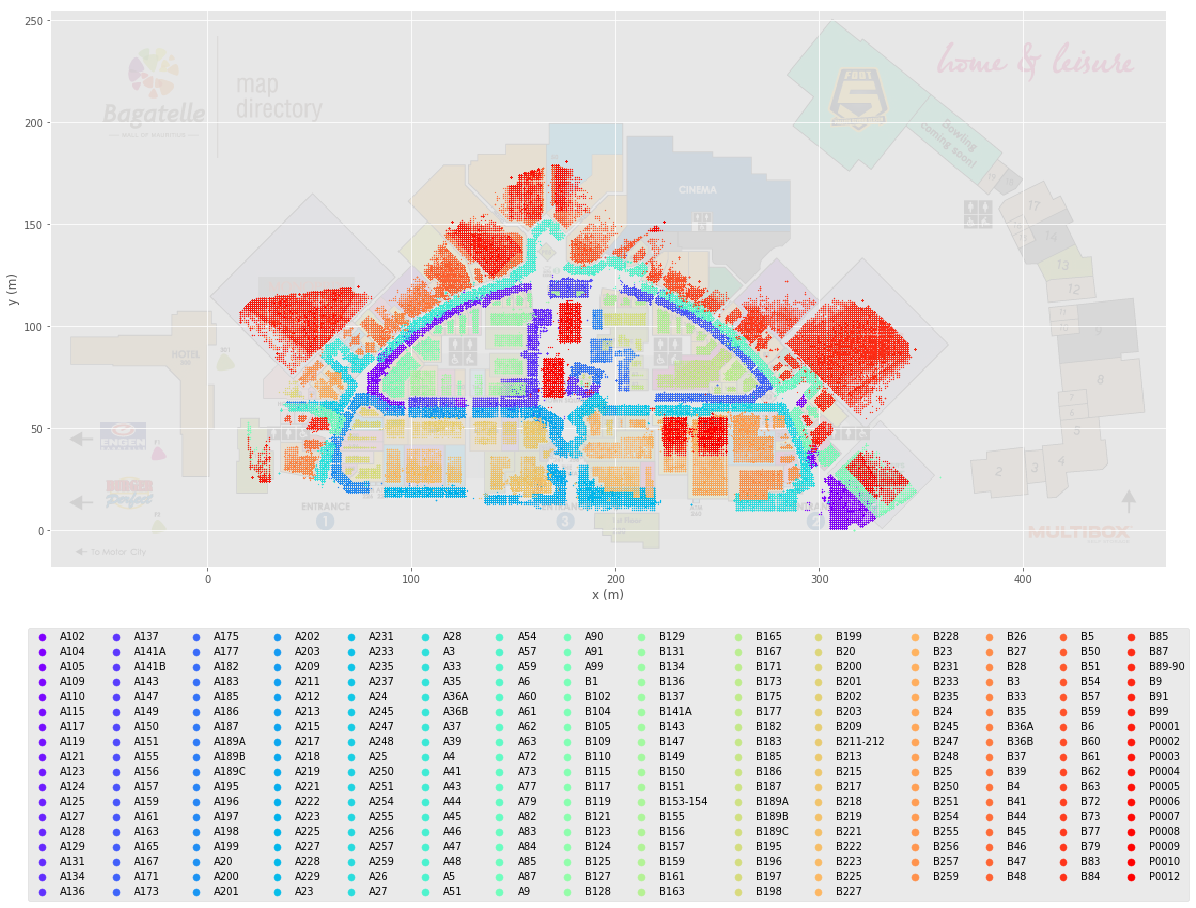

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

img = mpimg.imread("../../images/mall_of_mauritius_map.png")
axes.imshow(img[::-1], origin='lower', extent=[-77,470,-18,255], alpha=0.1)

mauritius_store_group = signal_df[signal_df.store_id.notnull()].groupby('store_id')
colors = iter(cm.rainbow(np.linspace(0, 1, len(mauritius_store_group))))
for key, group in mauritius_store_group:
    axes.scatter(group['x'], group['y'], s=0.5, color=next(colors), label=key)
    
axes.set_xlabel('x (m)')
axes.set_ylabel('y (m)')
axes.legend(loc='upper center', markerscale=10., ncol=15, bbox_to_anchor=(0.5, -0.1));

## Create Shop Data Frame

In [62]:
shops = signal_df[signal_df.store_id.notnull()].groupby('store_id')

shops = signal_df[signal_df.store_id.str[0] == 'B'].store_id.value_counts()
shop_df = pd.DataFrame(shops)
shop_df.rename(columns={'store_id': 'frequency'}, inplace=True)
shop_df['store_id'] = shop_df.index
shop_df.reset_index(inplace=True, drop=True)

In [63]:
def shop_areas(signal_df, shop_df):
    areas = []
    dimensions = []
    centroid = []
    shops = shop_df.store_id.tolist()

    signal_sorted_df = signal_df.sort_values('date_time')
    signal_store_group = signal_sorted_df.groupby('store_id')

    for shop in tqdm(shops, desc='Average Speed'):
        store_signals_df = signal_store_group.get_group(shop)
        xy = store_signals_df[['x', 'y']].as_matrix()
        centroid.append(list(np.mean(xy, axis=0)))
        pos = xy.tolist()
        key = list(set(xy[:, 0]))
        xy_dict = {k: [] for k in key}
        for (i, j) in pos:
            xy_dict[i].append(j)
        area = []
        dims = {}
        for k in key:
            y_max = np.amax(xy_dict[k])
            y_min = np.amin(xy_dict[k])
            area.append(y_max - y_min)
            dims[k] = [y_min, y_max]
        dimensions.append(dims)
        areas.append(np.sum(area))
    return areas, dimensions, centroid

In [64]:
shop_df['area'], shop_df['dimensions'], shop_df['centroid'] = shop_areas(signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Average Speed', max=126), HTML(value='')))

In [73]:
shop_df.centroid

0      [318.978504891, 89.3886541805]
1      [246.728776318, 43.3501127771]
2      [118.165212658, 125.091226525]
3       [266.812001906, 46.961018711]
4       [50.058532675, 106.375237649]
5      [158.007088372, 24.7189827511]
6      [136.182023508, 139.518237689]
7      [228.104873433, 47.6080356439]
8       [270.491565452, 103.09851552]
9      [104.839434112, 110.611462868]
10     [242.306196014, 78.2479085901]
11     [325.693778667, 22.6399454741]
12     [105.812036531, 30.2866286785]
13     [270.902017381, 22.1165114836]
14      [299.67508856, 47.0065638675]
15     [155.942440257, 167.246266085]
16      [172.563301938, 174.16504004]
17      [161.12405809, 48.7866602731]
18     [150.653159341, 104.921291209]
19     [239.583821376, 118.011054173]
20     [228.998918263, 121.123634637]
21     [89.2079876362, 102.035735589]
22     [23.1200781744, 26.6710639765]
23     [184.610446985, 137.343381843]
24     [92.8809984747, 74.9971547577]
25     [265.188261649, 72.5851851852]
26     [84.7

## Create Shop Distance Matrix

In [66]:
distance = lambda p1, p2: np.sqrt((p1.centroid[0] - p2.centroid[0])**2 + (p1.centroid[1] - p2.centroid[1])**2)

shop_distance_matrix = np.zeros((len(shop_df), len(shop_df)))

for i in tqdm(range(shop_distance_matrix.shape[0])):
    for j in range(shop_distance_matrix.shape[1]):
        shop_distance_matrix[i][j] = distance(shop_df.iloc[i], shop_df.iloc[j])

## Output Shop Data Frame

In [68]:
# shop_df.to_csv('mauritius_directoryv2.csv', index=False)

In [23]:
shop_df = utils.import_shop_directory(version=2)

In [24]:
count_of_shoppers = []
signal_group = signal_df.groupby('store_id')
for shop in shop_df.store_id.tolist():
    group = signal_group.get_group(shop)
    count_of_shoppers.append(len(group.mac_address.unique()))
shop_df['count_of_shoppers'] = count_of_shoppers

In [36]:
area_shop_df = shop_df[(shop_df.area > 0) & (shop_df.count_of_shoppers > 0)]

In [37]:
x = area_shop_df.area
y = area_shop_df.count_of_shoppers

In [41]:
from scipy.stats import linregress

In [53]:
slope, intercept, x_value, p_value, std_err = linregress(np.log10(x), np.log10(y))

In [71]:
std_err

0.036115051188779473

In [70]:
slope

0.60943616566142833

In [59]:
x_test = np.linspace(1, 10**4, 10)
y_test = [10**intercept*x**slope for x in x_test]

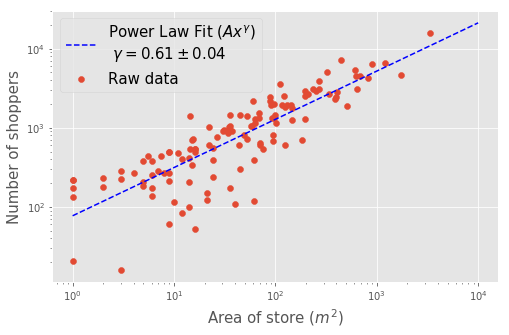

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

ax.scatter(x, y, label='Raw data')
ax.plot(x_test, y_test, 'b--', label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=0.61 \pm 0.04$')

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Number of shoppers', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)

fig.savefig('area_vs_number_of_shoppers.eps', format='eps', transparent=True)